# Almgren-Chriss Framework – Quadratic Execution Costs

## Objective
Implement the **original Almgren-Chriss (2001)** optimal execution model in its **simplest and most elegant form**:
- **Quadratic execution costs**: $ L(\rho) = \eta \rho^2 $, where $ \rho = \frac{|v_t|}{V} $
- **Constant market volume** $ V $
- **Closed-form analytical solution** using hyperbolic functions

This notebook applies the model to both:
1. **Stock market data** (if available from S3)
2. **Cryptocurrency data** (always available via Binance API)

---

## Model (Almgren-Chriss, 2001)

### Price Dynamics (with Permanent Impact)
$$
dS_t = \sigma \, dW_t + b \, v_t \, dt
$$
> $ v_t = \dot{q}_t $: trading speed  
> $ b $: permanent impact coefficient  
> $ \sigma $: annualized volatility

### Execution Costs (Temporary / Instantaneous Impact)
$$
L(\rho) = \eta \rho^2, \quad \rho_t = \frac{|v_t|}{V}
$$

### Optimization Objective
$$
\min_{v_t} \quad \mathbb{E}\left[ X_T \right] + \frac{\lambda}{2} \operatorname{Var}\left[ X_T \right]
$$

### Optimal Trajectory (Closed-Form Solution)
$$
\boxed{
q^*(t) = q_0 \frac{\sinh \left( \kappa (T - t) \right)}{\sinh (\kappa T)}
}
\quad \text{with} \quad
\boxed{
\kappa = \sqrt{\frac{\lambda \sigma^2 V}{2 \eta}}
}
$$

## Setup

In [132]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Graphics configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Create results directory
Path('results').mkdir(exist_ok=True)

print("✅ Imports successful")

✅ Imports successful


## Load Market Data & Parameters

In [133]:
# Load market parameters
df_params = pd.read_parquet('data/processed/market_parameters.parquet')

# Try to load calibrated parameters
try:
    with open('../results/calibrated_parameters.json', 'r') as f:
        calibrated = json.load(f)
    
    calibrated_available = True
    print("✅ Calibrated parameters loaded from results/calibrated_parameters.json")
    print(f"   Calibrated on: {calibrated.get('timestamp', 'N/A')}")
    print(f"   Symbol: {calibrated.get('symbol', 'N/A')}")
    print(f"   Number of snapshots: {calibrated.get('num_snapshots', 'N/A')}")
except FileNotFoundError:
    calibrated_available = False
    print("⚠️ No calibrated parameters found")
    print("   Run notebook 06_parameter_calibration.ipynb first to calibrate parameters")
    print("   Using literature-based parameters as fallback")

# Check which data is available
stocks_available = os.path.exists('data/processed/stocks/all_stocks_1m.parquet')
crypto_available = len(df_params[df_params['asset_type'] == 'crypto']) > 0

print("\n📊 Available data:")
print(f"   Stocks: {'✅ Yes' if stocks_available else '❌ No'}")
print(f"   Crypto: {'✅ Yes' if crypto_available else '❌ No'}")
print(f"   Calibrated params: {'✅ Yes' if calibrated_available else '❌ No'}")
print(f"\nThis notebook will execute on: {'stocks and crypto' if stocks_available and crypto_available else 'crypto only' if crypto_available else 'ERROR: no data'}")

✅ Calibrated parameters loaded from results/calibrated_parameters.json
   Calibrated on: 2025-12-06T23:20:25.496384
   Symbol: BTCUSDT
   Number of snapshots: 360

📊 Available data:
   Stocks: ❌ No
   Crypto: ✅ Yes
   Calibrated params: ✅ Yes

This notebook will execute on: crypto only


## Almgren-Chriss Model Class

In [134]:
class AlmgrenChrissQuadratic:
    """
    Almgren-Chriss (2001) optimal execution model - Quadratic execution costs.
    
    Closed-form solution using hyperbolic functions.
    """
    
    def __init__(self, lambda_risk, sigma, b, eta, V):
        self.lambda_risk = lambda_risk
        self.sigma = sigma
        self.b = b
        self.eta = eta
        self.V = V
    
    def compute_kappa(self):
        """κ = √(λ σ² V / (2 η))"""
        return np.sqrt(self.lambda_risk * self.sigma**2 * self.V / (2 * self.eta))
    
    def optimal_trajectory(self, q0, T, N=390):
        """Compute optimal trajectory q*(t), v*(t)"""
        kappa = self.compute_kappa()
        t = np.linspace(0, T, N+1)
        q_star = q0 * np.sinh(kappa * (T - t)) / np.sinh(kappa * T)
        v_star = q0 * (-kappa) * np.cosh(kappa * (T - t)) / np.sinh(kappa * T)
        return t, q_star, v_star
    
    def compute_costs(self, q0, T, N, strategy='optimal'):
        """Compute execution costs"""
        if strategy == 'optimal':
            t, q, v = self.optimal_trajectory(q0, T, N)
        elif strategy in ['twap', 'vwap']:
            t = np.linspace(0, T, N+1)
            q = q0 * (1 - t / T)
            v = -(q0 / T) * np.ones_like(t)
        else:
            raise ValueError(f"Unknown strategy: {strategy}")
        
        dt = T / N
        rho = np.abs(v) / self.V
        execution_cost = np.sum(self.eta * rho[:-1]**2 * dt)
        permanent_impact = self.b * abs(q0) / 2
        timing_risk_variance = self.sigma**2 * np.sum(q[:-1]**2 * dt)
        timing_risk = (self.lambda_risk / 2) * timing_risk_variance
        total_cost = execution_cost + permanent_impact + timing_risk
        
        return {
            'execution_cost': execution_cost,
            'permanent_impact': permanent_impact,
            'timing_risk': timing_risk,
            'total_cost': total_cost
        }

print("✅ AlmgrenChrissQuadratic class defined")

✅ AlmgrenChrissQuadratic class defined


---
# Part 1: Stock Market Analysis

Application to **AAPL** (Apple Inc.) - 6.5 hour trading day

In [135]:
if stocks_available:
    print("="*70)
    print("PART 1: STOCK MARKET - AAPL")
    print("="*70)
    
    # Load stock data
    df_stocks = pd.read_parquet('data/processed/stocks/all_stocks_1m.parquet')
    TICKER_STOCK = 'AAPL'
    data_stock = df_stocks[df_stocks['ticker'] == TICKER_STOCK]
    
    print(f"\n✅ Stock data loaded for {TICKER_STOCK}")
    print(f"   Period: {data_stock.index.min()} → {data_stock.index.max()}")
    print(f"   Rows: {len(data_stock):,}")
else:
    print("⚠️ Stock data not available - skipping Part 1")

⚠️ Stock data not available - skipping Part 1


### 1.1 Parameters for Stocks

In [136]:
if stocks_available:
    # Extract parameters
    params_stock = df_params[
        (df_params['symbol'] == TICKER_STOCK) & 
        (df_params['asset_type'] == 'stock')
    ].iloc[0]
    
    sigma_stock = params_stock['vol_annual']
    V_stock = params_stock['volume_per_day']
    S0_stock = data_stock['close'].iloc[-1]
    
    # Literature parameters
    b_stock = 0.0025
    eta_stock = 0.10
    lambda_risk_stock = 5e-6
    
    # Execution scenario
    q0_stock = 200_000  # shares
    T_stock = 1.0  # day
    N_stock = 390  # 6.5 hours = 390 minutes
    
    print("\n📋 Stock Parameters (AAPL):")
    print(f"   σ (volatility)      = {sigma_stock:.4f} ({sigma_stock*100:.1f}%)")
    print(f"   V (daily volume)    = {V_stock:,.0f} shares/day")
    print(f"   S₀ (price)          = ${S0_stock:.2f}")
    print(f"   b (permanent)       = {b_stock}")
    print(f"   η (execution)       = {eta_stock}")
    print(f"   λ (risk aversion)   = {lambda_risk_stock}")
    print(f"\n🎯 Execution Scenario:")
    print(f"   q₀ = {q0_stock:,} shares")
    print(f"   T  = {T_stock} day ({N_stock} minutes = 6.5h trading hours)")
    print(f"   Notional = ${q0_stock * S0_stock:,.0f}")

### 1.2 Optimal Trajectory for Stocks

In [137]:
if stocks_available:
    # Create model
    model_stock = AlmgrenChrissQuadratic(lambda_risk_stock, sigma_stock, b_stock, eta_stock, V_stock)
    
    # Compute trajectories
    t_opt_stock, q_opt_stock, v_opt_stock = model_stock.optimal_trajectory(q0_stock, T_stock, N_stock)
    t_twap_stock = np.linspace(0, T_stock, N_stock+1)
    q_twap_stock = q0_stock * (1 - t_twap_stock / T_stock)
    v_twap_stock = -(q0_stock / T_stock) * np.ones_like(t_twap_stock)
    
    print("\n✅ Optimal trajectory computed")
    print(f"   Initial velocity: {v_opt_stock[0]:,.0f} shares/day ({abs(v_opt_stock[0])/V_stock*100:.2f}% of market)")
    print(f"   Final velocity: {v_opt_stock[-1]:,.0f} shares/day ({abs(v_opt_stock[-1])/V_stock*100:.2f}% of market)")
    print(f"   TWAP velocity: {v_twap_stock[0]:,.0f} shares/day ({abs(v_twap_stock[0])/V_stock*100:.2f}% of market)")

### 1.3 Visualizations for Stocks

In [138]:
if stocks_available:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Position trajectory
    ax = axes[0]
    ax.plot(t_opt_stock * N_stock, q_opt_stock / 1000, label='Optimal', color='tab:blue', linewidth=2.5)
    ax.plot(t_twap_stock * N_stock, q_twap_stock / 1000, '--', label='TWAP', color='tab:red', linewidth=2)
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Position (thousands of shares)')
    ax.set_title(f'Liquidation Trajectory - {TICKER_STOCK} (Stock)', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Velocity
    ax = axes[1]
    ax.plot(t_opt_stock * N_stock, v_opt_stock / 1000, label='Optimal', color='tab:green', linewidth=2.5)
    ax.axhline(v_twap_stock[0] / 1000, color='tab:red', linestyle='--', linewidth=2, label='TWAP')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Velocity (thousands of shares/day)')
    ax.set_title(f'Execution Speed - {TICKER_STOCK} (Stock)', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 1.4 Cost Analysis for Stocks

In [139]:
if stocks_available:
    # Compute costs
    costs_opt_stock = model_stock.compute_costs(q0_stock, T_stock, N_stock, 'optimal')
    costs_twap_stock = model_stock.compute_costs(q0_stock, T_stock, N_stock, 'twap')
    
    # Display
    df_costs_stock = pd.DataFrame({
        'Optimal': costs_opt_stock,
        'TWAP': costs_twap_stock
    }).T
    
    print(f"\n💰 Cost Comparison - {TICKER_STOCK} (Stock)")
    print("\nIn dollars:")
    for col in ['execution_cost', 'permanent_impact', 'timing_risk', 'total_cost']:
        print(f"   {col:20s}: Optimal ${df_costs_stock.loc['Optimal', col]*S0_stock:,.0f}  |  TWAP ${df_costs_stock.loc['TWAP', col]*S0_stock:,.0f}")
    
    # In bps
    notional_stock = q0_stock * S0_stock
    opt_bps_stock = (costs_opt_stock['total_cost'] * S0_stock / notional_stock) * 10000
    twap_bps_stock = (costs_twap_stock['total_cost'] * S0_stock / notional_stock) * 10000
    
    print(f"\nIn basis points:")
    print(f"   Optimal: {opt_bps_stock:.2f} bps")
    print(f"   TWAP: {twap_bps_stock:.2f} bps")
    print(f"   Gain: {twap_bps_stock - opt_bps_stock:.2f} bps ({(twap_bps_stock - opt_bps_stock)/twap_bps_stock*100:.1f}%)")

---
# Part 2: Cryptocurrency Analysis

Application to **BTCUSDT** (Bitcoin) - 24 hour continuous trading

In [140]:
if crypto_available:
    print("="*70)
    print("PART 2: CRYPTOCURRENCY - BTCUSDT")
    print("="*70)
    
    # Load crypto data
    SYMBOL_CRYPTO = 'BTCUSDT'
    data_crypto = pd.read_parquet(f'data/processed/crypto/{SYMBOL_CRYPTO}_1m.parquet')
    
    print(f"\n✅ Crypto data loaded for {SYMBOL_CRYPTO}")
    print(f"   Period: {data_crypto['timestamp'].min()} → {data_crypto['timestamp'].max()}")
    print(f"   Rows: {len(data_crypto):,}")
else:
    print("❌ Crypto data not available - cannot proceed")

PART 2: CRYPTOCURRENCY - BTCUSDT

✅ Crypto data loaded for BTCUSDT
   Period: 2025-11-01 00:00:00 → 2025-12-01 00:00:00
   Rows: 43,201


### 2.1 Parameters for Crypto

In [141]:
if crypto_available:
    # Extract parameters
    params_crypto = df_params[
        (df_params['symbol'] == SYMBOL_CRYPTO) & 
        (df_params['asset_type'] == 'crypto')
    ].iloc[0]
    
    sigma_crypto = params_crypto['vol_annual']
    V_crypto = params_crypto['volume_per_day']
    S0_crypto = data_crypto['close'].iloc[-1]
    
    # Use CALIBRATED parameters if available, otherwise use literature values
    if calibrated_available and calibrated.get('symbol') == SYMBOL_CRYPTO:
        print("\n🎯 Using CALIBRATED parameters:")
        k_crypto = calibrated['parameters']['k']
        psi_crypto = calibrated['parameters']['psi']
        
        # For quadratic model, convert from power-law
        # Quadratic model: L(ρ) = η ρ²
        # We approximate η from calibrated parameters
        eta_crypto = calibrated['parameters']['eta']
        
        print(f"   k (permanent impact) = {k_crypto:.8f} [calibrated from order book]")
        print(f"   η (execution cost)   = {eta_crypto:.6f} [calibrated from order book]")
        print(f"   ψ (spread)           = {psi_crypto:.6f} ({psi_crypto*10000:.2f} bps) [calibrated]")
        
        print(f"\n   📊 Calibration quality:")
        print(f"      R² (Kyle's lambda): {calibrated['goodness_of_fit']['kyle_r_squared']:.4f}")
        if calibrated['goodness_of_fit'].get('powerlaw_r_squared'):
            print(f"      R² (power-law):     {calibrated['goodness_of_fit']['powerlaw_r_squared']:.4f}")
    else:
        print("\n📚 Using LITERATURE-based parameters (fallback):")
        k_crypto = 0.0025
        eta_crypto = 0.10
        psi_crypto = 0.002
        
        print(f"   k (permanent impact) = {k_crypto}")
        print(f"   η (execution cost)   = {eta_crypto}")
        print(f"   ψ (spread)           = {psi_crypto} ({psi_crypto*10000:.0f} bps)")
        print(f"   ⚠️ These are generic values - calibrate for better accuracy")
    
    lambda_risk_crypto = 5e-6
    
    print(f"\n   λ (risk aversion)    = {lambda_risk_crypto}")
    
    # Execution scenario
    q0_crypto = 100  # BTC (more realistic than 200k)
    T_crypto = 5.0  # day
    N_crypto = 1440  # 24 hours = 1440 minutes
    
    print(f"\n📋 Crypto Parameters (BTCUSDT):")
    print(f"   σ (volatility)      = {sigma_crypto:.4f} ({sigma_crypto*100:.1f}%)")
    print(f"   V (daily volume)    = {V_crypto:,.0f} BTC/day")
    print(f"   S₀ (price)          = ${S0_crypto:.2f}")
    print(f"   b (permanent)       = {k_crypto:.8f}")
    print(f"   η (execution)       = {eta_crypto:.6f}")
    print(f"   λ (risk aversion)   = {lambda_risk_crypto}")
    print(f"\n🎯 Execution Scenario:")
    print(f"   q₀ = {q0_crypto:,} BTC")
    print(f"   T  = {T_crypto} day ({N_crypto} minutes = 24h continuous trading)")
    print(f"   Notional = ${q0_crypto * S0_crypto:,.0f}")


🎯 Using CALIBRATED parameters:
   k (permanent impact) = 0.00000555 [calibrated from order book]
   η (execution cost)   = 0.452225 [calibrated from order book]
   ψ (spread)           = 0.000050 (0.50 bps) [calibrated]

   📊 Calibration quality:
      R² (Kyle's lambda): 0.9973
      R² (power-law):     0.9739

   λ (risk aversion)    = 5e-06

📋 Crypto Parameters (BTCUSDT):
   σ (volatility)      = 0.5193 (51.9%)
   V (daily volume)    = 25,320 BTC/day
   S₀ (price)          = $90408.34
   b (permanent)       = 0.00000555
   η (execution)       = 0.452225
   λ (risk aversion)   = 5e-06

🎯 Execution Scenario:
   q₀ = 100 BTC
   T  = 5.0 day (1440 minutes = 24h continuous trading)
   Notional = $9,040,834


### 2.2 Optimal Trajectory for Crypto

In [142]:
if crypto_available:
    # Create model (use k_crypto as permanent impact parameter)
    model_crypto = AlmgrenChrissQuadratic(lambda_risk_crypto, sigma_crypto, k_crypto, eta_crypto, V_crypto)
    
    # Compute trajectories
    t_opt_crypto, q_opt_crypto, v_opt_crypto = model_crypto.optimal_trajectory(q0_crypto, T_crypto, N_crypto)
    t_twap_crypto = np.linspace(0, T_crypto, N_crypto+1)
    q_twap_crypto = q0_crypto * (1 - t_twap_crypto / T_crypto)
    v_twap_crypto = -(q0_crypto / T_crypto) * np.ones_like(t_twap_crypto)
    
    print("\n✅ Optimal trajectory computed")
    print(f"   Initial velocity: {v_opt_crypto[0]:,.2f} BTC/day ({abs(v_opt_crypto[0])/V_crypto*100:.2f}% of market)")
    print(f"   Final velocity: {v_opt_crypto[-1]:,.2f} BTC/day ({abs(v_opt_crypto[-1])/V_crypto*100:.2f}% of market)")
    print(f"   TWAP velocity: {v_twap_crypto[0]:,.2f} BTC/day ({abs(v_twap_crypto[0])/V_crypto*100:.2f}% of market)")


✅ Optimal trajectory computed
   Initial velocity: -25.93 BTC/day (0.10% of market)
   Final velocity: -17.17 BTC/day (0.07% of market)
   TWAP velocity: -20.00 BTC/day (0.08% of market)


### 2.3 Visualizations for Crypto

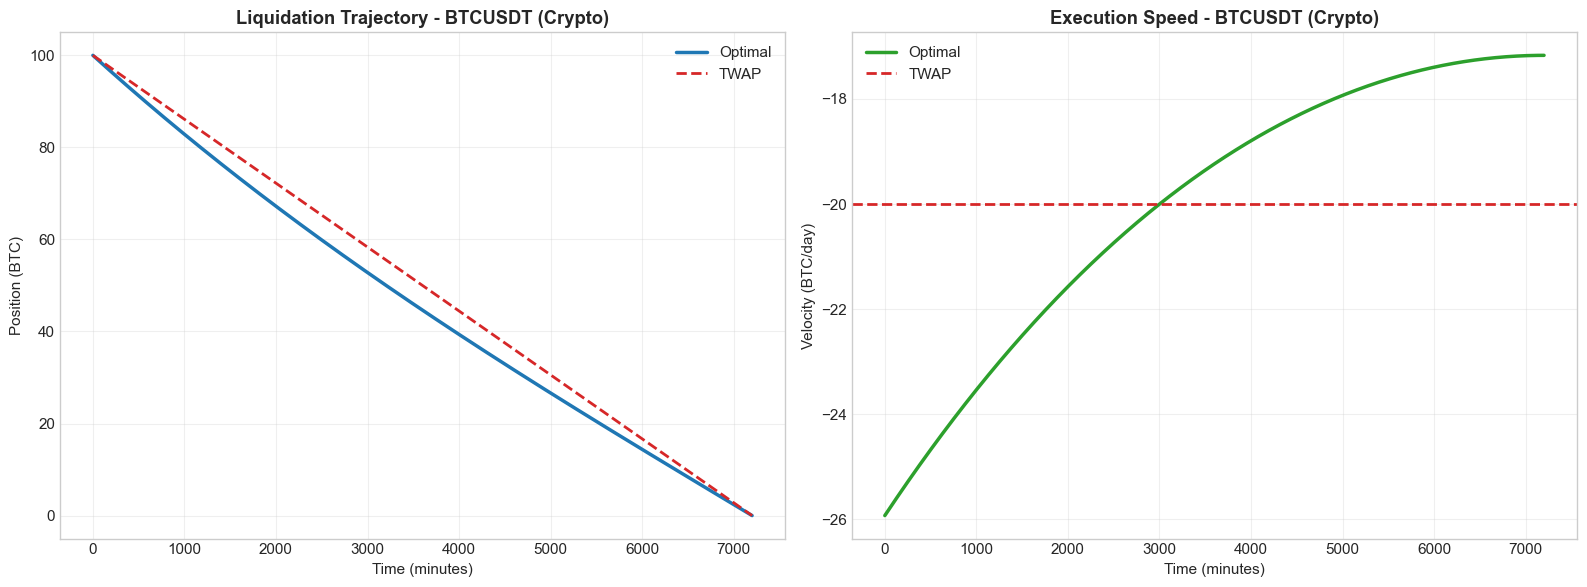

In [143]:
if crypto_available:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Position trajectory
    ax = axes[0]
    ax.plot(t_opt_crypto * N_crypto, q_opt_crypto, label='Optimal', color='tab:blue', linewidth=2.5)
    ax.plot(t_twap_crypto * N_crypto, q_twap_crypto, '--', label='TWAP', color='tab:red', linewidth=2)
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Position (BTC)')
    ax.set_title(f'Liquidation Trajectory - {SYMBOL_CRYPTO} (Crypto)', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Velocity
    ax = axes[1]
    ax.plot(t_opt_crypto * N_crypto, v_opt_crypto, label='Optimal', color='tab:green', linewidth=2.5)
    ax.axhline(v_twap_crypto[0], color='tab:red', linestyle='--', linewidth=2, label='TWAP')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Velocity (BTC/day)')
    ax.set_title(f'Execution Speed - {SYMBOL_CRYPTO} (Crypto)', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 2.4 Cost Analysis for Crypto

In [144]:
if crypto_available:
    # Compute costs
    costs_opt_crypto = model_crypto.compute_costs(q0_crypto, T_crypto, N_crypto, 'optimal')
    costs_twap_crypto = model_crypto.compute_costs(q0_crypto, T_crypto, N_crypto, 'twap')
    
    # Display
    df_costs_crypto = pd.DataFrame({
        'Optimal': costs_opt_crypto,
        'TWAP': costs_twap_crypto
    }).T
    
    print(f"\n💰 Cost Comparison - {SYMBOL_CRYPTO} (Crypto)")
    print("\nIn dollars:")
    for col in ['execution_cost', 'permanent_impact', 'timing_risk', 'total_cost']:
        print(f"   {col:20s}: Optimal ${df_costs_crypto.loc['Optimal', col]*S0_crypto:,.0f}  |  TWAP ${df_costs_crypto.loc['TWAP', col]*S0_crypto:,.0f}")
    
    # In bps
    notional_crypto = q0_crypto * S0_crypto
    opt_bps_crypto = (costs_opt_crypto['total_cost'] * S0_crypto / notional_crypto) * 10000
    twap_bps_crypto = (costs_twap_crypto['total_cost'] * S0_crypto / notional_crypto) * 10000
    
    print(f"\nIn basis points:")
    print(f"   Optimal: {opt_bps_crypto:.2f} bps")
    print(f"   TWAP: {twap_bps_crypto:.2f} bps")
    print(f"   Gain: {twap_bps_crypto - opt_bps_crypto:.2f} bps ({(twap_bps_crypto - opt_bps_crypto)/twap_bps_crypto*100:.1f}%)")


💰 Cost Comparison - BTCUSDT (Crypto)

In dollars:
   execution_cost      : Optimal $0  |  TWAP $0
   permanent_impact    : Optimal $25  |  TWAP $25
   timing_risk         : Optimal $904  |  TWAP $1,017
   total_cost          : Optimal $930  |  TWAP $1,042

In basis points:
   Optimal: 1.03 bps
   TWAP: 1.15 bps
   Gain: 0.12 bps (10.8%)


---
# Summary & Comparison

In [145]:
print("="*70)
print("SUMMARY - STOCKS vs CRYPTO")
print("="*70)

if stocks_available and crypto_available:
    print(f"\n{'Metric':<30} {'Stock (AAPL)':<25} {'Crypto (BTCUSDT)':<25}")
    print("-"*70)
    print(f"{'Volatility (annual)':<30} {sigma_stock*100:>6.2f}% {sigma_crypto*100:>24.2f}%")
    print(f"{'Daily Volume':<30} {V_stock:>22,.0f} {V_crypto:>27.2f}")
    print(f"{'Price':<30} ${S0_stock:>23.2f} ${S0_crypto:>26.2f}")
    print(f"{'Position Size':<30} {q0_stock:>16,} shares {q0_crypto:>20.0f} BTC")
    print(f"{'Trading Hours':<30} {N_stock:>14} min (6.5h) {N_crypto:>16} min (24h)")
    print(f"{'Notional':<30} ${q0_stock*S0_stock:>21,.0f} ${q0_crypto*S0_crypto:>24,.0f}")
    print(f"\n{'Optimal Cost (bps)':<30} {opt_bps_stock:>24.2f} {opt_bps_crypto:>27.2f}")
    print(f"{'TWAP Cost (bps)':<30} {twap_bps_stock:>24.2f} {twap_bps_crypto:>27.2f}")
    print(f"{'Optimization Gain (%)':<30} {(twap_bps_stock-opt_bps_stock)/twap_bps_stock*100:>23.1f}% {(twap_bps_crypto-opt_bps_crypto)/twap_bps_crypto*100:>26.1f}%")
elif crypto_available:
    print(f"\nOnly crypto data analyzed:")
    print(f"   {SYMBOL_CRYPTO}: Optimal = {opt_bps_crypto:.2f} bps, TWAP = {twap_bps_crypto:.2f} bps")
    print(f"   Gain: {(twap_bps_crypto-opt_bps_crypto)/twap_bps_crypto*100:.1f}%")
else:
    print("\n❌ No data available for analysis")

SUMMARY - STOCKS vs CRYPTO

Only crypto data analyzed:
   BTCUSDT: Optimal = 1.03 bps, TWAP = 1.15 bps
   Gain: 10.8%


## Save Results

In [146]:
results = {
    'execution_date': datetime.now().isoformat(),
    'model': 'Almgren-Chriss Quadratic'
}

if stocks_available:
    results['stock'] = {
        'ticker': TICKER_STOCK,
        'parameters': {'sigma': sigma_stock, 'V': V_stock, 'S0': S0_stock, 'q0': q0_stock, 'N': N_stock},
        'costs_optimal_bps': opt_bps_stock,
        'costs_twap_bps': twap_bps_stock
    }

if crypto_available:
    results['crypto'] = {
        'symbol': SYMBOL_CRYPTO,
        'parameters': {'sigma': sigma_crypto, 'V': V_crypto, 'S0': S0_crypto, 'q0': q0_crypto, 'N': N_crypto},
        'costs_optimal_bps': opt_bps_crypto,
        'costs_twap_bps': twap_bps_crypto
    }

with open('results/02_almgren_chriss_basic_results.json', 'w') as f:
    json.dump(results, f, indent=2, default=float)

print("✅ Results saved to results/02_almgren_chriss_basic_results.json")

✅ Results saved to results/02_almgren_chriss_basic_results.json
